# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

<hr>
<div align='center'><b>Описание данных</b></div>

<ul> 
<li><b>id</b> — уникальный идентификатор скважины;</li>
<li><b>f0, f1, f2</b> — три признака точек (неважно, что они означают, но сами признаки значимы);</li>
<li><b>product</b> — объём запасов в скважине (тыс. баррелей).</li>
</ul>

<hr>
<div align='center'><b>План работы</b></div>

1. Загрузка и подготовка данных
2. Обучение и проверка модели
3. Подготовка к расчёту прибыли
4. Расчёт прибыли и рисков
5. Итоговые выводы

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import math
import re
import csv
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import logging
import contextlib
import sys


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Загрузка и подготовка данных

In [3]:
def csv_download(file_name: str) -> pd.DataFrame:
    '''Accepts the name of the file(the file name is specified with the extension, 
    if the file does not lie in the folder with this notebook, 
    the full path should be specified). 
    Selects the delimiter and decimal separator for correct data reading.
    Returns the DataFrame object obtained from the file with the passed name.'''
    
    sniffer = csv.Sniffer()
    with open(file_name) as file:
        sample = file.read(5000)
        delimiter = sniffer.sniff(sample).delimiter
        
        file.seek(0)
        reader = csv.reader(file, delimiter=delimiter)
        decimal_counts = {'.': 0, ',': 0}
        for row in reader:
            for cell in row:
                if re.match(r'^\d+,\d+$', cell):
                    decimal_counts[','] += 1
                elif re.match(r'^\d+\.\d+$', cell):
                    decimal_counts['.'] += 1
        decimal_separator = max(decimal_counts, key=decimal_counts.get)
        
        file.seek(0)
        data = pd.read_csv(file, decimal=decimal_separator, delimiter=delimiter)
        
    return data

In [4]:
def batch_opening(file_names: list[str]) -> tuple[pd.DataFrame]:
    '''Accepts a list with file names 
    (the file name is specified with the extension, 
    if the file does not lie in the folder with this notebook, 
    the full path should be specified). 
    Returns a tuple of DataFrame objects, 
    the number of which is equal to the number of file names.'''
    
    results = []
    for file_name in file_names:
        results.append(csv_download(file_name))
    return results

In [5]:
def show_data(frame_names: list[str]) -> None:
    '''Takes a list of DataFrame names, and for each name, 
    it prints a formatted header, displays the first few rows, 
    and shows the summary information of the corresponding DataFrame.'''
    
    for i, data in enumerate(frame_names, 0):
        print()
        print(f"\033[92mДАННЫЕ ИЗ ФАЙЛА \033[1m{data}".center(140))
        display(globals()[data].head())
        display(globals()[data].info())

In [6]:
def cor_heatmap(df: pd.DataFrame, parameters: list[str], 
                kind: str = 'Spearman', n_round: int=2,
                figsize: tuple[int] = (10, 10)) -> None:
    '''Heatmap of the correlation matrix (df[parameters])'''
    
    if kind == 'Phik':
        types = df.dtypes.reset_index()
        types.columns = ['index', 'type']
        quantitive = list(types.loc[(types['type'] == 'int64') | (types['type'] == 'float64'), 'index'])
        data_corr = df[parameters].phik_matrix(quantitive)
    elif kind == 'Pearson':
        data_corr = df[parameters].corr()
    elif kind == 'Spearman':
        data_corr = df[parameters].corr(method='spearman')
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(data_corr, dtype=bool))
    sns.heatmap(data_corr, 
                annot=True, 
                cmap='coolwarm',
                mask=mask,
                fmt=f".{n_round}f", 
                vmin=-1, 
                vmax=1, 
                center=0) 
    plt.title(f'Матрица корреляций, использующая метод {kind}', 
                 weight='bold', 
                 size=15, 
                 color='darkred', 
                 pad=20)
    plt.show()

<hr>

Загрузим данные из файлов и посмотрим основную информацию о них.

<hr>

In [7]:
file_names=['/datasets/geo_data_0.csv', 
            '/datasets/geo_data_1.csv', 
            '/datasets/geo_data_2.csv']
geo_data_0, geo_data_1, geo_data_2 = batch_opening(file_names)

In [8]:
show_data(['geo_data_0', 'geo_data_1', 'geo_data_2'])


                                                    ДАННЫЕ ИЗ ФАЙЛА geo_data_0                                                     


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


                                                    ДАННЫЕ ИЗ ФАЙЛА geo_data_1                                                     


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


                                                    ДАННЫЕ ИЗ ФАЙЛА geo_data_2                                                     


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<hr>

Посмотрим наличие дубликатов по "id" в фреймах.

<hr>

In [9]:
for data in ['geo_data_0', 'geo_data_1', 'geo_data_2']:
    print(f"Дубликаты id в фрейме {data}: {globals()[data]['id'].duplicated().sum()}")

Дубликаты id в фрейме geo_data_0: 10
Дубликаты id в фрейме geo_data_1: 4
Дубликаты id в фрейме geo_data_2: 4


In [10]:
geo_data_0[geo_data_0['id'].duplicated(keep=False)].sort_values('id')

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


<hr>

Данные дублируются, возможно по этим скважинам были проведены дополнительные геологические исследования, котороые помогли уточнить результаты, уберем строчки с меньшим значением.

<hr>

In [11]:
geo_data_0 = geo_data_0.loc[geo_data_0.groupby('id')['product'].idxmax()].reset_index(drop=True)
geo_data_1 = geo_data_1.loc[geo_data_1.groupby('id')['product'].idxmax()].reset_index(drop=True)
geo_data_2 = geo_data_2.loc[geo_data_2.groupby('id')['product'].idxmax()].reset_index(drop=True)

In [12]:
geo_data_0

,id,f0,f1,f2,product
0,006OJ,1.289189,-0.623324,3.642039,142.822141
1,009eY,1.958091,0.268711,3.702938,112.036815
2,00AfQ,0.558807,-0.366895,-1.268154,49.659570
3,00AuZ,-0.968699,0.416057,3.553416,73.351787
4,00BTM,-0.908137,0.036964,1.053951,38.664619
...,...,...,...,...,...
99985,zzrmI,-0.696760,0.642588,0.132320,83.962231
99986,zzsy6,1.018014,-0.333769,2.309579,123.664999
99987,zztWK,-0.265504,1.037058,3.769413,158.177578
99988,zzyhQ,0.076828,0.278057,2.267372,156.258013


In [13]:
for data in ['geo_data_0', 'geo_data_1', 'geo_data_2']:
    print(f"Дубликаты id в фрейме {data}: {globals()[data]['id'].duplicated().sum()}")

Дубликаты id в фрейме geo_data_0: 0
Дубликаты id в фрейме geo_data_1: 0
Дубликаты id в фрейме geo_data_2: 0


<hr>

Построим матрицу корреляций.

<hr>

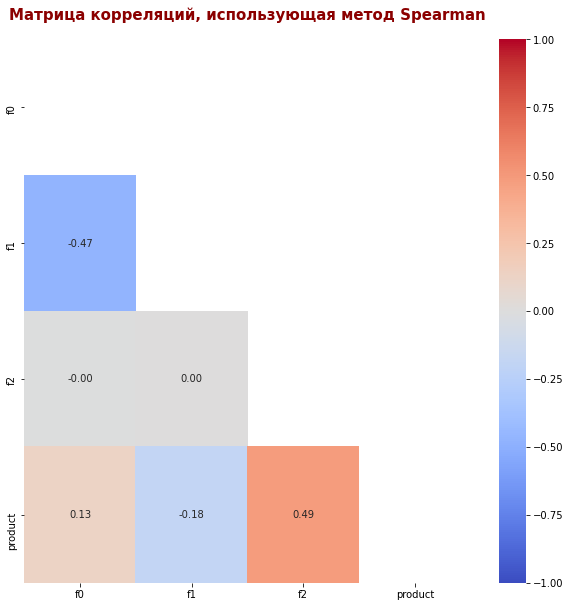

In [14]:
cor_heatmap(geo_data_0, geo_data_0.columns.drop('id'))

<hr>
<font size=4.5><b>Итоги раздела:</b></font>

<p style='text-align: justify;'>В данном разделе были загружены данные из 3-х файлов в формате <i>.csv</i>. Данные в файлах соответствуют описанию. Были обнаружены 18 дубликатов "id", дубликаты с меньшим показателем объемов запасов были удалены.</p>

 - <b>geo_data_0</b> содержит 99990 строк и 5 столбцов. Пропущенных занчений нет. Типы данных: <i><font color='purple'>float</font></i> и <i><font color='purple'>str</font></i>.
 - <b>geo_data_1</b> содержит 99996 строк и 5 столбцов. Пропущенных занчений нет. Типы данных: <i><font color='purple'>float</font></i> и <i><font color='purple'>str</font></i>.
 - <b>geo_data_2</b> содержит 99996 строк и 5 столбцов. Пропущенных занчений нет. Типы данных: <i><font color='purple'>float</font></i> и <i><font color='purple'>str</font></i>.

Построена матрица корреляций, значения коэффициентов не превышают 0.9, в данных не наблюдается мультиколлинеарность.

<hr>

## Обучение и проверка модели

In [15]:
def standard_quant_params(quant_params: list[str], 
                          X_train: pd.DataFrame, 
                          X_test: pd.DataFrame) -> tuple[pd.DataFrame, StandardScaler]: 
    '''Normalization of quantitative parameters using StandardScaler'''
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[quant_params])
    X_test_scaled = scaler.transform(X_test[quant_params])
    
    scaled_train_data = pd.DataFrame(X_train_scaled, columns=quant_params)
    scaled_test_data = pd.DataFrame(X_test_scaled, columns=quant_params)
    
    return scaler, scaled_train_data, scaled_test_data

In [16]:
def residuals_analysis(y_test: pd.DataFrame, predictions: np.ndarray, 
                       figsize: tuple[int]=(16, 8), 
                       title_size: int=18, xy_labels_size: int=12) -> pd.DataFrame:
    '''Construction of residuals histogram and scatter plot '''
    
        
    residuals = y_test - predictions
    
    fig = plt.figure(figsize=figsize)
    
    
    fig.add_subplot(1, 2, 1)
    plt.hist(residuals, bins=20)
    plt.title('Гистограмма распределения остатков', 
              size=title_size, 
              weight='bold',
              color='DarkRed')
    plt.xlabel('Остатки', 
               size=xy_labels_size, 
               weight='bold')
    plt.grid()
    
    
    fig.add_subplot(1, 2, 2)
    plt.scatter(predictions, 
                residuals, 
                alpha=0.3)
    plt.title('Анализ дисперсии', 
              size=title_size, 
              weight='bold',
              color='DarkRed')
    plt.xlabel('Предсказания модели', 
               size=xy_labels_size, 
               weight='bold')
    plt.ylabel('Остатки', 
               size=xy_labels_size, 
               weight='bold')
    plt.grid()
    
    
    plt.show()
    return residuals

In [17]:
RANDOM_STATE = 1
TEST_SIZE = 0.25

                                                          geo_data_0                                                           
Средний запас предсказанного сырья: 92.55
RMSE модели: 37.73



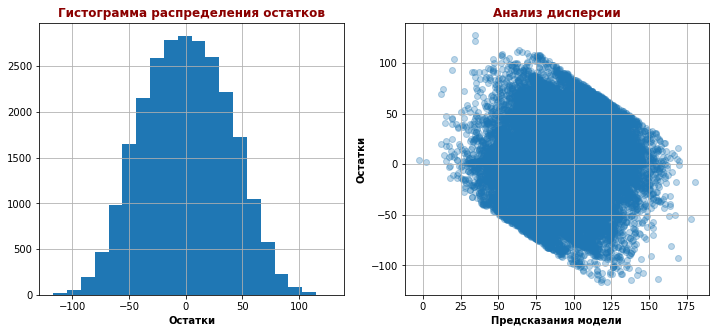


                                                          geo_data_1                                                           
Средний запас предсказанного сырья: 68.73
RMSE модели: 0.89



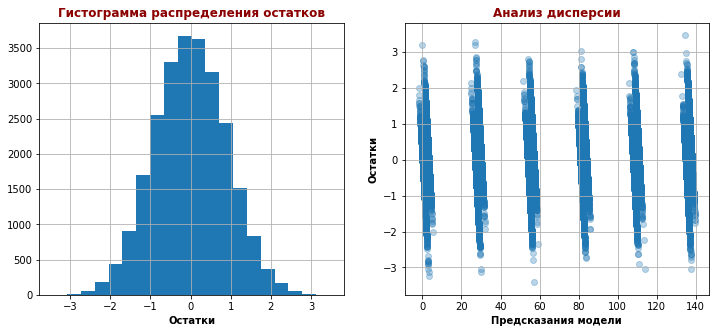


                                                          geo_data_2                                                           
Средний запас предсказанного сырья: 95.05
RMSE модели: 40.09



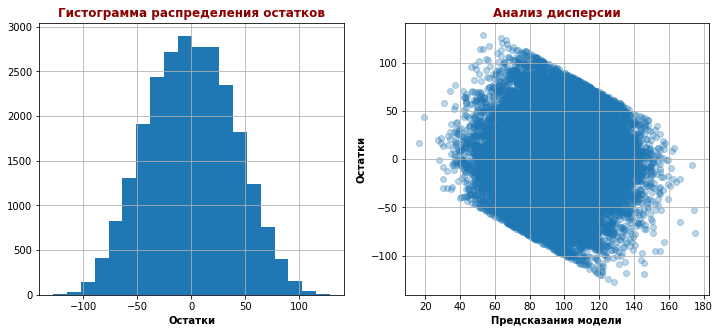

In [18]:
preds_gd = {'geo_data_0':'pred_gd_0', 'geo_data_1':'pred_gd_1', 'geo_data_2':'pred_gd_2'}

for geo_data in ['geo_data_0', 'geo_data_1', 'geo_data_2']:  
    X_train, X_test, y_train, y_test = train_test_split(globals()[geo_data][['f0', 'f1', 'f2']], 
                                                        globals()[geo_data]['product'], 
                                                        test_size=TEST_SIZE, 
                                                        random_state=RANDOM_STATE)
    
    _, scaled_train_data, scaled_test_data = standard_quant_params(quant_params=['f0', 
                                                                                 'f1', 
                                                                                 'f2'], 
                                                                   X_train=X_train, 
                                                                   X_test=X_test)
    
    model = LinearRegression()
    model.fit(scaled_train_data, y_train)
    predictions = model.predict(scaled_test_data)
    
    globals()[preds_gd[geo_data]] = X_test.copy()
    globals()[preds_gd[geo_data]]['product'] = y_test
    globals()[preds_gd[geo_data]]['prediction'] = predictions
    
    rmse = mean_squared_error(globals()[preds_gd[geo_data]]['product'], 
                              globals()[preds_gd[geo_data]]['prediction'], 
                              squared=False)
    average_stock = globals()[preds_gd[geo_data]]['prediction'].mean()
    
    print(f"\033[92m\033[1m{geo_data}\033[0m".center(140))
    print(f"\033[1mСредний запас предсказанного сырья: {round(average_stock, 2)}")
    print(f"RMSE модели: {round(rmse, 2)}", end="\n\n")
    residuals = residuals_analysis(y_test=y_test, 
                                   predictions=predictions, 
                                   figsize=(12, 5), 
                                   title_size=12, 
                                   xy_labels_size=10)
    print()

<hr>
<font size=4.5><b>Итоги раздела:</b></font>

<p style='text-align: justify;'>В данном разделе были обучены 3 модели линейной регрессии для каждого региона. Предсказания каждой модели были сохранены в отдельный фрейм, а также был посчитан средний запас предсказанного сырья и рассчитана RMSE модели.</p>

Анализ остатков каждой модели показал:

 - У всех моделей гистограммы остатков имеют вид нормального распределения и не смещены, это означает, что в среднем модели не завышают и не занижают результат предсказания;
 - <p style='text-align: justify;'>По дисперсиям моделей для первого (<b>geo_data_0</b>) и третьего (<b>geo_data_2</b>) регионов видно, что при низких значениях предсказаний - примерно до 80, модель занижает результаты, при этом при предсказанных значениях более 120, модель наоборот завышает значения предсказаний, в среднем модель завышает предсказания на столько же, на сколько и занижает. Это означает, что там где модель предсказала высокий запас сырья, скорее всего он будет меньше, при этом там, где она предсказала низкий запас, он будет выше, таким образом в среднем по региону объем запасов будет равен предсказанному объему по региону;</p>
 - <p style='text-align: justify;'>На графике диспперсии второй модели (<b>geo_data_1</b>) видно, что разброс остатков равномерный, поэтому при любых предсказанных значениях, действительное значение запаса должно быть близко к предсказанному. Это означает, что если необходимо будет выбрать скважины с наибольшими запасами в регионе, стоит сравнить их с максимальными запасами по этому региону, так как если значения будут близки, надежнее будет выбрать скважены из данного региона из-за меньшего разброса на высоких значениях.</p>

<hr>

## Подготовка к расчёту прибыли

In [19]:
def revenue_calculation(df: pd.DataFrame, 
                        predictions: str, 
                        true_values: str) -> int:
    '''Calculates the expected revenue 
    based on the predicted raw material volume from oil wells.'''
    
    best_wells = df.sort_values(predictions, ascending=False).iloc[:BEST_WELLS_AMOUNT]
    raw_material_volume = best_wells[true_values].sum()
    revenue = raw_material_volume * REVENUE_PER_UNIT - BUDGET
    
    return revenue

In [20]:
def show_geo_revenues(i: int, predictions_geo: pd.Series) -> None:    
    '''Visualizes the potential profits from drilling wells in a specified geographical region'''
    
    state = np.random.RandomState(12345)
    revenues = pd.Series([revenue_calculation(predictions_geo.sample(n=TEST_WELLS_AMOUNT, replace=True, random_state=state), 
                                              predictions='prediction', 
                                              true_values='product') 
                          for i in range(1000)])
    average_revenue = revenues.mean()
    lower_limit = revenues.quantile(0.025)
    upper_limit = revenues.quantile(0.975)
    loss_risk = len(revenues[revenues < 0]) / 1000 * 100
    
    
    plt.figure(figsize=(9, 8))
    revenues.hist(bins=30)
    plt.axvline(lower_limit, color='red', linestyle='dashed', linewidth=1)
    plt.axvline(upper_limit, color='red', linestyle='dashed', linewidth=1)
    
    
    legend_text = f'''Средняя прибыль: {int(average_revenue // 1e6)} млн.
Нижняя граница доверительного интервала: {lower_limit / 1e6:.2f} млн.
Верхняя граница доверительного интервала: {upper_limit / 1e6:.2f} млн.
Риск убытков: {loss_risk:.2f}%'''
    
    plt.legend([legend_text], bbox_to_anchor=(2, 1), fontsize=14, handlelength=0)
    
    plt.title(f'Распределение возможной прибыли от скважин\nиз региона geo_{i}', 
              size=15, 
              weight='bold', 
              color='DarkRed')
    plt.xlabel('Значение прибыли, в млн., от 200 из 500 скважин\nс наибольшим предсказанным запасом сырья', 
               size=12, 
               weight='bold')
    plt.ylabel('Количество в выборке', 
               size=12, 
               weight='bold')
    plt.show()

In [21]:
TEST_WELLS_AMOUNT = 500
BEST_WELLS_AMOUNT = 200
BUDGET = 10e9
REVENUE_PER_UNIT = 450e3  

predictions = [pred_gd_0, pred_gd_1, pred_gd_2]

<hr>

Рассчитаем средний объем сырья, достаточный для безубыточной разработки новой скважины. При расчете будем учитывать:

 - При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки;
 - Бюджет на разработку скважин в регионе — 10 млрд рублей;
 - При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей;

<hr>

In [22]:
average_breakeven_well_yield = BUDGET / BEST_WELLS_AMOUNT / REVENUE_PER_UNIT
print(f"Средний объем сырья в скважине, достаточный для ее безубыточной разработки: {round(average_breakeven_well_yield, 2)}")

Средний объем сырья в скважине, достаточный для ее безубыточной разработки: 111.11


<hr>
<font size=4.5><b>Итоги раздела:</b></font>

<p style='text-align: justify;'>В данном разделе был рассчитан достаточный объем сырья для безубыточной разработки новой скважины. Он получился равным 111.1 тысяч баррелей, ни в одном из регионов по предсказаниям модели нет достаточного среднего запаса сырья.</p>

<p style='text-align: justify;'>Полученные результаты могут говорить о том, что при <u>случайном</u> выборе 200 скважин, без использования моделей для предсказания, вероятнее всего объема сырья в данных скважинах будет недостаточно даже для покрытия расходов на разработку этих скважин.</p>

<hr>

## Расчёт прибыли и рисков 

<hr>

Рассчитаем возможную прибыль для каждого региона. Оценим Среднее значение прибыли, 95%-й доверительный интервал и риск убытков.

<hr>

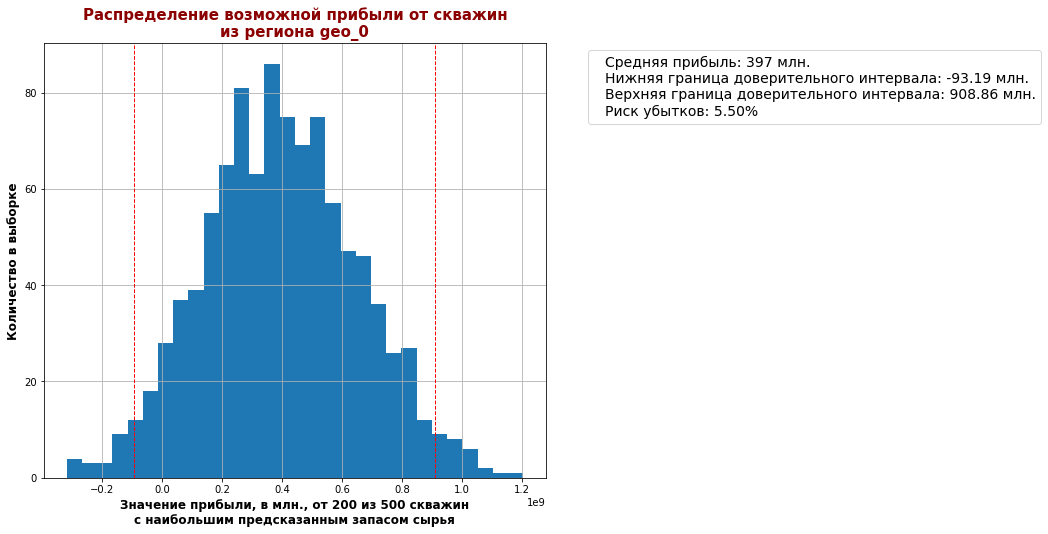

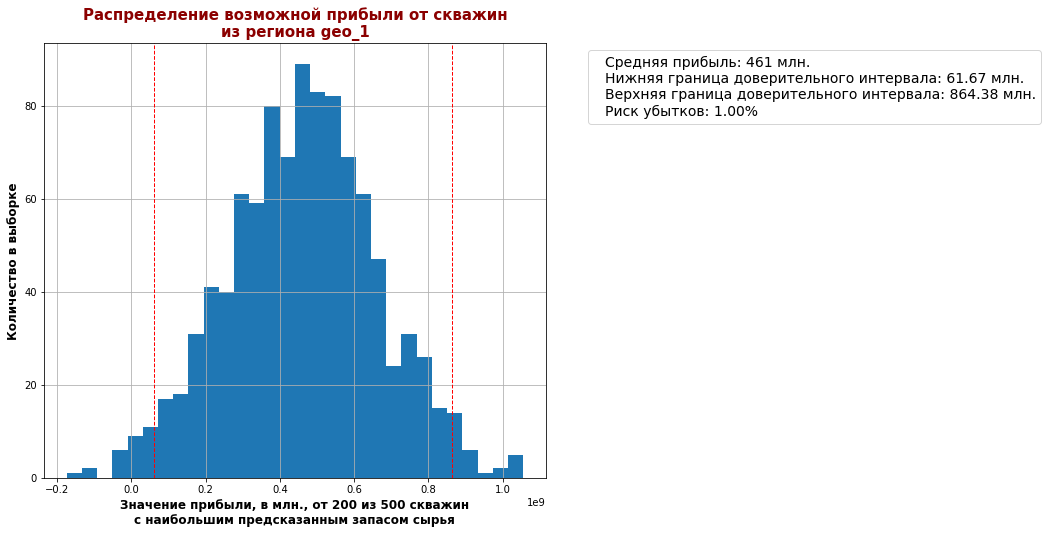

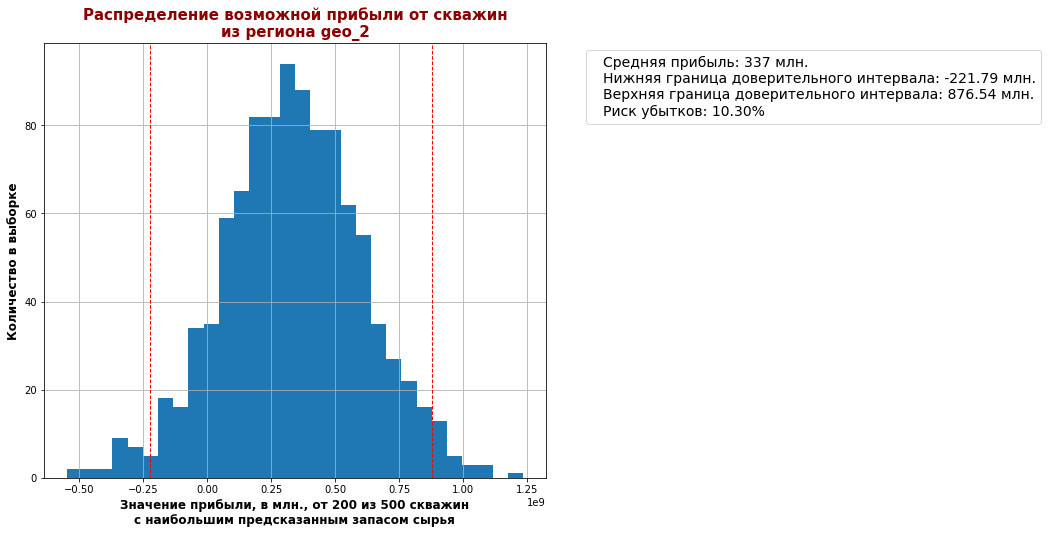

In [23]:
for i, predictions_geo in enumerate(predictions):
    show_geo_revenues(i, predictions_geo)

<hr>
<font size=4.5><b>Итоги раздела:</b></font>

<p style='text-align: justify;'>В данном разделе для трех регионов были рассчитаны средняя прибыль, 95%-й доверительный интервал и риск убытков. Только у одного региона вероятность убытков получилась менее 2.5%, это регион - <b>geo_1</b>, со значением средней прибыли - 461 мнл. В остальных регионах слишком высокая вероятность убытков.<br><br>Исходя из вышесказанного для разработки рекомендуется регион <b>geo_1.</b></p>

<hr>

## Итоговые выводы

<p style='text-align: justify;'>В данной работе был проведен анализ данных, содаержащих характеристики нефтеных скважин, для компании <b>«ГлавРосГосНефть»</b>, была проанализирована возможная прибыль и риски для регионов, в результате чего определен регион с максимальной суммарной прибылью отобранных скважин.</p>

<p style='text-align: justify;'>В результате предобработки данных, были обнаружены 18 дубликатов "id", дубликаты с меньшим показателем объемов запасов были удалены.</p>

Построена матрица корреляций, значения коэффициентов не превышают 0.9, в данных не наблюдается мультиколлинеарность.

<p style='text-align: justify;'>Далее были обучены 3 модели линейной регрессии для каждого региона. Предсказания каждой модели были сохранены в отдельный фрейм, а также был посчитан средний запас предсказанного сырья и рассчитана RMSE модели.</p>

Анализ остатков каждой модели показал:

 - У всех моделей гистограммы остатков имеют вид нормального распределения и не смещены, это означает, что в среднем модели не завышают и не занижают результат предсказания;
 - <p style='text-align: justify;'>По дисперсиям моделей для первого (<b>geo_data_0</b>) и третьего (<b>geo_data_2</b>) регионов видно, что при низких значениях предсказаний - примерно до 80, модель занижает результаты, при этом при предсказанных значениях более 120, модель наоборот завышает значения предсказаний, в среднем модель завышает предсказания на столько же, на сколько и занижает. Это означает, что там где модель предсказала высокий запас сырья, скорее всего он будет меньше, при этом там, где она предсказала низкий запас, он будет выше, таким образом в среднем по региону объем запасов будет равен предсказанному объему по региону;</p>
 - <p style='text-align: justify;'>На графике диспперсии второй модели (<b>geo_data_1</b>) видно, что разброс остатков равномерный, поэтому при любых предсказанных значениях, действительное значение запаса должно быть близко к предсказанному. Это означает, что если необходимо будет выбрать скважины с наибольшими запасами в регионе, стоит сравнить их с максимальными запасами по этому региону, так как если значения будут близки, надежнее будет выбрать скважены из данного региона из-за меньшего разброса на высоких значениях.</p>

<p style='text-align: justify;'>Для безубыточной разработки новой скважины рассчитан достаточный объем сырья. Он получился равным 111.1 тысяч баррелей, ни в одном из регионов по предсказаниям модели нет достаточного среднего запаса сырья.</p>

<p style='text-align: justify;'>Полученные результаты могут говорить о том, что при <u>случайном</u> выборе 200 скважин, без использования моделей для предсказания, вероятнее всего объема сырья в данных скважинах будет недостаточно даже для покрытия расходов на разработку этих скважин.</p>

<p style='text-align: justify;'>Далее для каждого региона была рассчитана прибыль, риски и 95%-й доверительный интервал с использованием техники <i>Bootstrap</i>. При рассчете учитывались следующие условия:</p>
    
 - При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
 - Бюджет на разработку скважин в регионе — 10 млрд рублей.
 - <p style='text-align: justify;'>При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.</p>
 - <p style='text-align: justify;'>После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.</p>
    
<p style='text-align: justify;'>Только у одного региона вероятность убытков получилась менее 2.5%, это регион - <b>geo_1</b>, со значением средней прибыли - 461 мнл.</p>

<p style='text-align: justify;'>Таким образом для разработки скважин рекомендуется регион <b>geo_1</b>.</p>